<a href="https://colab.research.google.com/github/hiteshisawariya485/Signature_Verification/blob/main/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, AveragePooling2D,
                                     Flatten, Dense, Dropout, concatenate, BatchNormalization,
                                     GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DATASET'

Mounted at /content/drive


In [ ]:
# Load and preprocess images
def load_data(image_size=(128, 128)):
    X, y = [], []
    for label, folder in enumerate(['full_forg', 'full_org']):
        folder_path = os.path.join(DATA_PATH, folder)
        for file in os.listdir(folder_path):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            img = img / 255.0
            img = img.reshape((*image_size, 1))
            X.append(img)
            y.append(label)
    return np.array(X), to_categorical(np.array(y), num_classes=2)

X, y = load_data()

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # First split: 70% train, 30% for val+test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42) # Second split: 15% val, 15% test


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = datagen.flow(X_train, y_train, batch_size=16)
val_gen = datagen.flow(X_val, y_val, batch_size=16)


In [ ]:
# Inception Module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)

    path2 = Conv2D(filters_3x3_reduce, (1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    path2 = Conv2D(filters_3x3, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(path2)

    path3 = Conv2D(filters_5x5_reduce, (1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    path3 = Conv2D(filters_5x5, (5,5), padding='same', activation='relu', kernel_regularizer=l2(0.001))(path3)

    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(path4)

    return concatenate([path1, path2, path3, path4], axis=-1)


In [ ]:
# Build Inception (GoogLeNet) Model
def build_inception_model(input_shape=(128, 128, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Compile model
model = build_inception_model()
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 1,113,698 (4.25 MB)

 Trainable params: 1,113,186 (4.25 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)


In [ ]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.6788 - loss: 2.5428 - val_accuracy: 0.6518 - val_loss: 2.3894
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7136 - loss: 2.2006 - val_accuracy: 0.6965 - val_loss: 2.0099
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7202 - loss: 1.8970 - val_accuracy: 0.7114 - val_loss: 1.7517
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7304 - loss: 1.6577 - val_accuracy: 0.7151 - val_loss: 1.5644
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7170 - loss: 1.4892 - val_accuracy: 0.7263 - val_loss: 1.3543
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7187 - loss: 1.3286 - val_accuracy: 0.7281 - val_loss: 1.2189
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7239 - loss: 1.1972 - val_accuracy: 0.6983 - val_loss: 1.1368
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6997 - loss: 1.0981 - val_accur

In [ ]:
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Test Accuracy: 0.4913
Validation Accuracy: 73.74%
Validation Loss: 0.5022


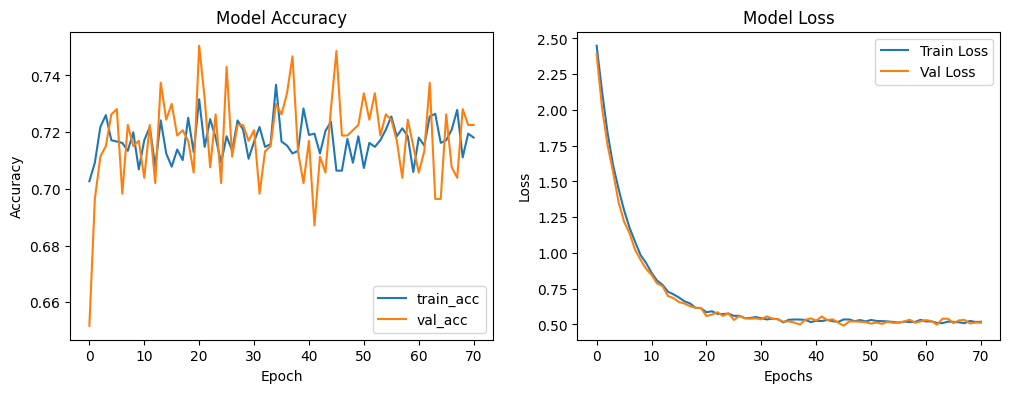

In [ ]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [ ]:
# Predict on Validation Data
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
# Get the true labels from y_val
# Reset the validation generator before predicting
val_gen.reset()
y_true = np.argmax(y_val, axis=-1)  # Use all y_val without indexing

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# Ensure both y_true and y_pred have the same length
num_samples = min(len(y_true), len(y_pred))
y_true = y_true[:num_samples]
y_pred = y_pred[:num_samples]


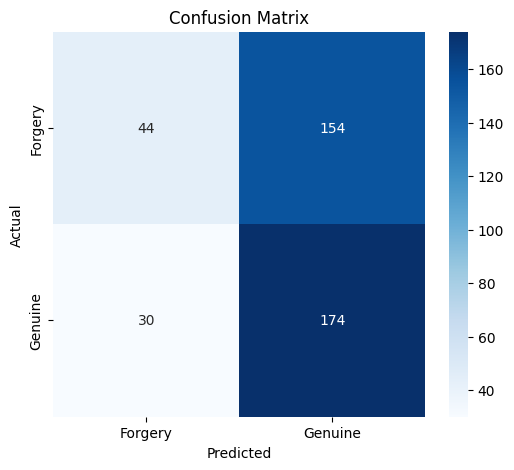

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Genuine'], yticklabels=['Forgery', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Precision, Recall, F1 score
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.5305
Recall:    0.8529
F1 Score:  0.6541
